MSE650 project by Siddharth Sachdeva (211035) and Manav Reddy (210583) - Determining orientation of an-isotropic image. Our aim is to determine the degree of orientation of a given image by determing the boundar length per unit area of the parallel component and perpendicular component of the image


Importing all the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color, filters, morphology, measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian, median
from skimage.morphology import remove_small_objects, closing, square, disk, binary_erosion, binary_dilation
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
# from google.colab import files

Code to upload the image

In [2]:
# uploaded = files.upload()

Code to convert image to greyscale image. The code extracts the three layers of the image - Red, Green and Blue and reduces them to single channel haivng pixel values between 0 and 255, each value representing the intensity of light

Text(0.5, 1.0, 'Grayscale image')

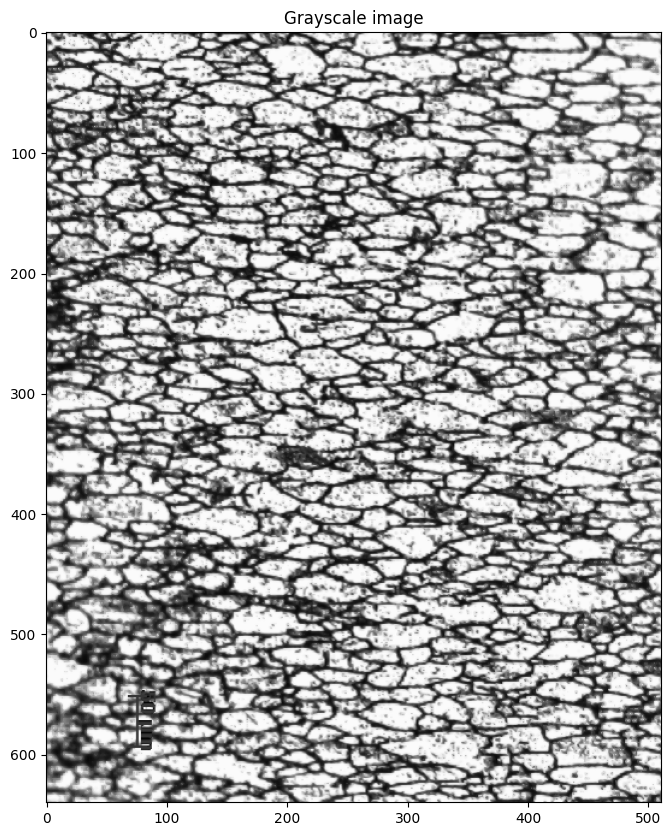

In [23]:
#conversion to grayscale
img = plt.imread('mse2.png')
img = img[:,:,0:3]
img = rgb2gray(img)

#display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
plt.title("Grayscale image")

Converting image to binary image. This conversion uses Otsu method which calculates a threshold above which all pixel values are converted to 1s while less than threshold are converted to 0s. It works by finding the value that minimizes the intra-class variance between the two groups of pixel intensities (foreground and background)



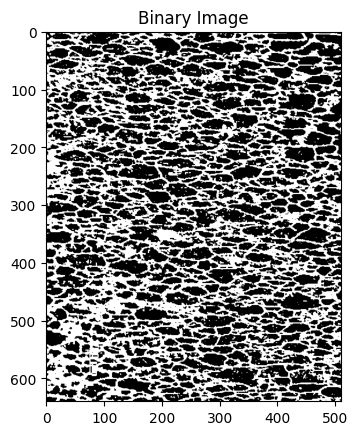

In [24]:
threshold_value = threshold_otsu(img)
binary_image = img < threshold_value
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Image")
plt.show()

To make the boundaries clearer, morphological reconstruction is used to expand selected regions in the binary image based on connectivity. First, a seed image is created by copying binary_image and setting the inner pixels to the image’s minimum value (usually False), providing a starting point for reconstruction. A mask, which is also a copy of binary_image, restricts the reconstruction to specific regions, allowing the seed to expand only within the True areas of the mask. The morphology.reconstruction function then iteratively dilates the seed image until it can no longer change without exceeding the mask’s limits. This produces a final image, binary_final, with clarified boundaries, highlighting specific connected regions in the original binary image.

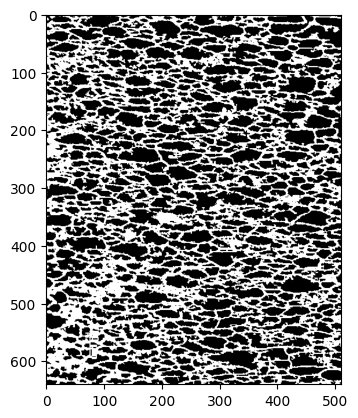

In [25]:
seed = binary_image.copy()
seed[1:-1, 1:-1] = binary_image.min()
mask = binary_image.copy()
binary_final = morphology.reconstruction(seed, mask, method='dilation')
plt.imshow(binary_final, cmap='gray')

After dilation, skeletonization has been appplied using morphology.skeletonize to the binary_final image. Skeletonization reduces the shapes to their thinnest form, preserving the essential structure while removing excess pixels. This operation results in a "skeleton" of the original object, which is useful for analyzing the core structure and connectivity of features within the image.

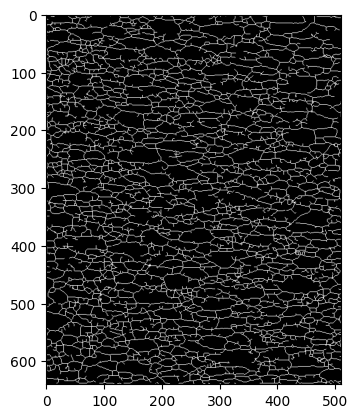

In [26]:
skeleton = morphology.skeletonize(binary_final)
plt.imshow(skeleton, cmap='gray')

Generation of radial probes. This code generates a visualisation of the radaia probes which are used to detect intersection points per total length. We have defined the center as the central coordinates of the image (width / 2 and length / 2). We have defined the radius as the half of the minimum dimension of the image(legth or breadth).




We are making an array of angles from 0 to 180, with gap of 10 degrees between each line probe. The "for" loop is used to draw the lines over varying angles. We use the concept of x = cx - r cos(theta) and y = cy - r sin(theta).




Line2d function takes the coordinates (x1,y1) and (x2,y2) and draw a lines between them

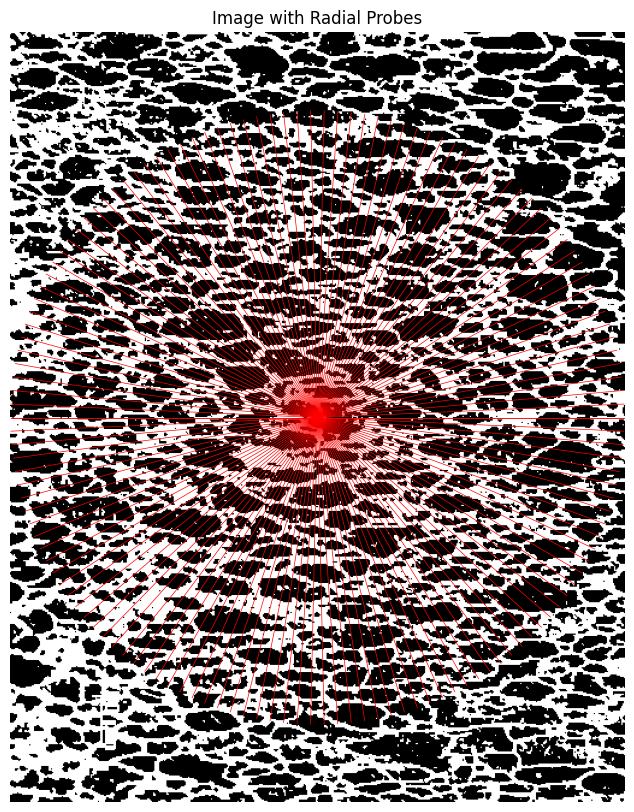

In [27]:
skeleton = binary_image.copy()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(skeleton, cmap='gray')
plt.title("Image with Radial Probes")

center_x, center_y = skeleton.shape[1] // 2, skeleton.shape[0] // 2

radius = min(skeleton.shape[0], skeleton.shape[1])//2
angles = np.linspace(0,180,num=72)

for angle in angles:
    end_x = center_x - radius * np.cos(np.deg2rad(angle))
    end_y = center_y - radius * np.sin(np.deg2rad(angle))
    start_x = center_x + radius * np.cos(np.deg2rad(angle))
    start_y = center_y + radius * np.sin(np.deg2rad(angle))
    line = Line2D([start_x, end_x], [start_y, end_y], color='red', linewidth=0.5)
    ax.add_line(line)

center_circle = Circle((center_x, center_y), radius=3, edgecolor='red', facecolor='red')

ax.add_patch(center_circle)

plt.axis('off')
plt.show()

Calculating the point fraction for each corresponding line probe. The idea used in this code draws radial lines 
from the center and evaluate the number of transitions between foreground and background pixels along these 
lines. We started by initialising an empty array point_fraction which will store point fraction corresponding 
to each angle.

First for loop is used to access the linear probe corresponding to an angle. Just like above we specify the end coordinates of x and y.

The function np.linspace is utmost important in this code. It takes a start value , end value (end coordinates of the line) , and num value, which is the number of pixels it want to store, which is equal to the units of radius. Hence this function stores all these values in the form of (x1,y1) / (x2,y2) / (num1,num2) (num 1 will be equal to num 2). This function forms "num1/num2" pairs of coordinates starting from center to end x,end y


To calculate intercepts, we initialise current pixel (start's pixel value) as previous pixel and as algorithm detects a transition in the pixel value from its movement from start to end coordinates, it adds 1 value to intercept and updates the previous pixel. Since each actual intercept results in two transitions, the final count is divided by 2 to avoid double-counting


Then, we append the point fraction of each probe in the point_fraction array. Point fractions appended here are overall point fractions, consisting of isotropic and oriented part

In [28]:
point_fraction = []


for theta in angles:
    end_x = center_x + int(radius * np.cos(np.radians(theta)))
    end_y = center_y + int(radius * np.sin(np.radians(theta)))
    start_x = center_x + int(radius * np.cos(np.deg2rad(angle))) 
    start_y = center_y + int(radius * np.sin(np.deg2rad(angle)))
    line_coords = list(zip(
        np.linspace(start_y, end_y, num=2*radius, dtype=int),
        np.linspace(start_x, end_x, num=2*radius, dtype=int)
    ))

    intercepts = 0
    previous_pixel = skeleton[line_coords[0]]
    for coord in line_coords[1:]:
        current_pixel = skeleton[coord]
        if current_pixel != previous_pixel:
            intercepts += 1
            previous_pixel = current_pixel
    intercepts = intercepts/2
    point_fraction.append(intercepts / 2*radius)


mean_point_fraction = np.mean(point_fraction)


print("Point Fraction:", point_fraction)
print("Mean Point Fraction:", mean_point_fraction)


boundary_length = np.pi * mean_point_fraction / 2
print("Boundary Length:", boundary_length)


Point Fraction: [3315.0, 3506.25, 2677.5, 2422.5, 2996.25, 3378.75, 3506.25, 3123.75, 3442.5, 2805.0, 3187.5, 3633.75, 3888.75, 3952.5, 3506.25, 2868.75, 2932.5, 3697.5, 3633.75, 4143.75, 3378.75, 3570.0, 3506.25, 3442.5, 3761.25, 3060.0, 2932.5, 4398.75, 3506.25, 3888.75, 3060.0, 2996.25, 2358.75, 2741.25, 2932.5, 3888.75, 3506.25, 3251.25, 3060.0, 3060.0, 3251.25, 2996.25, 2550.0, 3187.5, 3123.75, 3697.5, 2486.25, 1976.25, 2040.0, 2295.0, 1848.75, 1466.25, 1338.75, 1083.75, 1912.5, 1466.25, 1402.5, 1147.5, 1211.25, 1338.75, 1083.75, 1083.75, 573.75, 637.5, 637.5, 446.25, 382.5, 318.75, 318.75, 191.25, 0.0, 0.0]
Mean Point Fraction: 2505.7291666666665
Boundary Length: 3935.990170942837


Code to plot a scatter plot between angles and point fraction

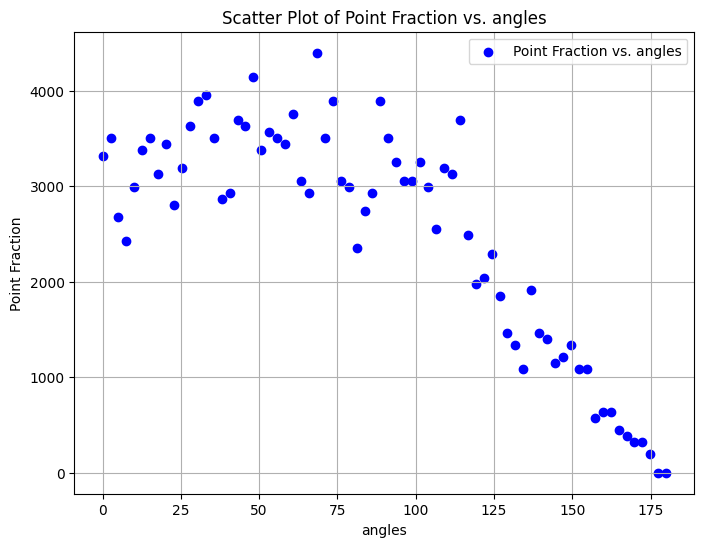

In [29]:

plt.figure(figsize=(8, 6))
plt.scatter(angles, point_fraction, color='blue', label="Point Fraction vs. angles")


plt.xlabel("angles")
plt.ylabel("Point Fraction")
plt.title("Scatter Plot of Point Fraction vs. angles")
plt.legend()
plt.grid(True)

plt.show()

This code plots a polynomial curve of degree 3 to present the line with least square error. We tried curve 2 initially but was not giving good enough result.

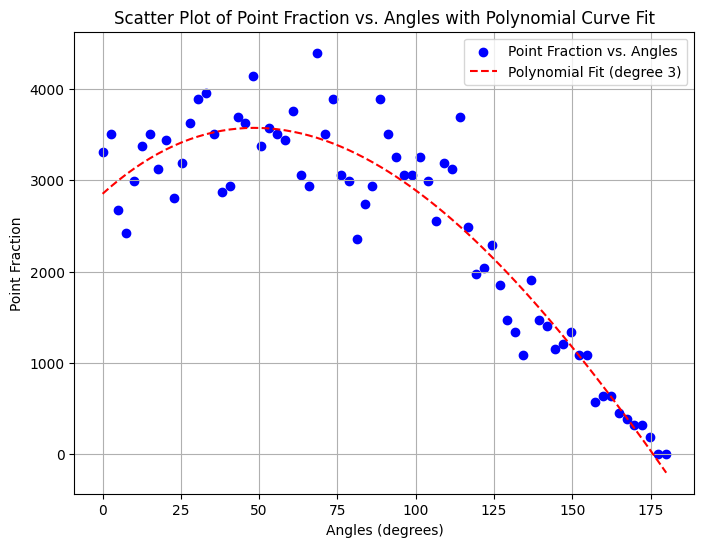

Polynomial Coefficients: [ 4.93448455e-04 -3.55237740e-01  3.09707924e+01  2.85236261e+03]


In [30]:


degree = 3
coefficients = np.polyfit(angles, point_fraction, degree)


polynomial = np.poly1d(coefficients)
curve_fit_values = polynomial(angles)

plt.figure(figsize=(8, 6))
plt.scatter(angles, point_fraction, color='blue', label="Point Fraction vs. Angles")
plt.plot(angles, curve_fit_values, color='red', linestyle='--', label=f"Polynomial Fit (degree {degree})")


plt.xlabel("Angles (degrees)")
plt.ylabel("Point Fraction")
plt.title("Scatter Plot of Point Fraction vs. Angles with Polynomial Curve Fit")
plt.legend()
plt.grid(True)

plt.show()

print("Polynomial Coefficients:", coefficients)



This code plots the graph between point fraction and sin(theta) of our angles.

In [31]:
# from scipy.stats import linregress
# slope, intercept, r_value, p_value, std_err = linregress(angles, point_fraction)
# regression_line = slope * angles + intercept
# plt.figure(figsize=(8, 6))
# plt.scatter(angles, point_fraction, color='blue', label="Point Fraction vs. angles")
# plt.plot(angles, regression_line, color='red', linestyle='--', label=f"Regression Line (y = {slope:.2f}x + {intercept:.2f})")

# plt.xlabel("angles")
# plt.ylabel("Point Fraction")
# plt.title("Scatter Plot of Point Fraction vs. angles with Regression Line")
# plt.legend()
# plt.grid(True)

# plt.show()

# print("Slope:", slope)
# print("Intercept:", intercept)

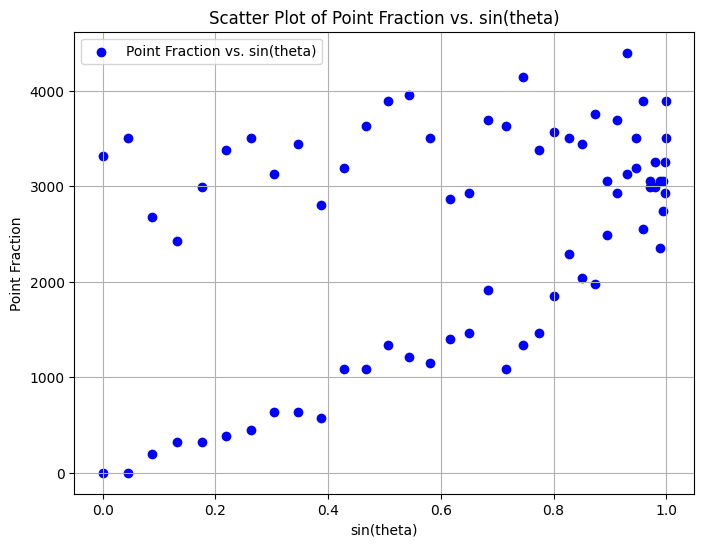

In [32]:
sin_angles = np.sin(np.radians(angles))


plt.figure(figsize=(8, 6))
plt.scatter(sin_angles, point_fraction, color='blue', label="Point Fraction vs. sin(theta)")


plt.xlabel("sin(theta)")
plt.ylabel("Point Fraction")
plt.title("Scatter Plot of Point Fraction vs. sin(theta)")
plt.legend()
plt.grid(True)

plt.show()


This code plots the regression line between point fraction and sin of angles. The regression line represents the equation

(Pl)overall = ((pl)perpendicular - (pl)paralle)*sin(angles) + (pl)parallel


Hence we use the slope and intercept of this regression line to obtain the values of (pl)parallel and (pl)perpendicular

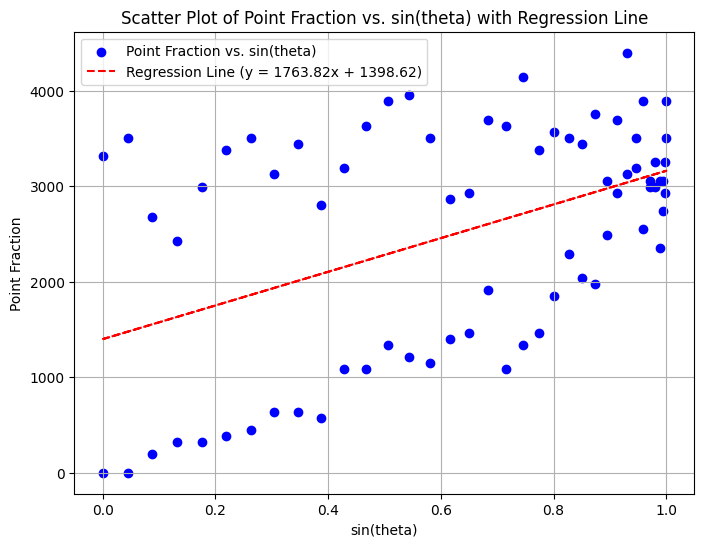

Slope: 1763.8191167717143
Intercept: 1398.6232929330927


In [33]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sin_angles, point_fraction)
regression_line = slope * sin_angles + intercept
plt.figure(figsize=(8, 6))
plt.scatter(sin_angles, point_fraction, color='blue', label="Point Fraction vs. sin(theta)")
plt.plot(sin_angles, regression_line, color='red', linestyle='--', label=f"Regression Line (y = {slope:.2f}x + {intercept:.2f})")

plt.xlabel("sin(theta)")
plt.ylabel("Point Fraction")
plt.title("Scatter Plot of Point Fraction vs. sin(theta) with Regression Line")
plt.legend()
plt.grid(True)

plt.show()

print("Slope:", slope)
print("Intercept:", intercept)

In [34]:
pl_parallel = 0
pl_perpendicular = 0
pl_parallel = intercept
pl_perpendicular = slope + pl_parallel
print(pl_parallel)
print(pl_perpendicular)

1398.6232929330927
3162.442409704807


Here we plot a radial plot between (pl) component of complety oriented lines and angles

(pl)perpendicular sin theta vs angles

In [35]:
pl_theta_perpendicular = []
for x in angles :
  line_theta = pl_parallel*np.sin(np.radians(x))
  pl_theta_perpendicular.append(line_theta)
print(pl_theta_perpendicular)

[0.0, 61.86578905450062, 123.61047292170632, 185.11318348341345, 246.25352629552694, 306.9118162658383, 366.9693119432142, 426.30844795956307, 484.8130651695638, 542.3686380376479, 598.8624988271135, 654.1840581525107, 708.2250214635562, 760.8796010368025, 812.044723060073, 861.6202294042903, 909.5090736877173, 955.6175112488063, 999.8552826557772, 1042.1357903936926, 1082.3762683831603, 1120.4979439988217, 1156.4261922704625, 1190.090681964899, 1221.425513262668, 1250.3693467600185, 1276.8655235436759, 1300.8621761033241, 1322.3123298646938, 1341.1739951444963, 1357.410249347202, 1370.9893092427535, 1381.884593183732, 1390.0747731401798, 1395.5438164502211, 1398.2810172047498, 1398.2810172047498, 1395.5438164502211, 1390.0747731401798, 1381.8845931837318, 1370.9893092427535, 1357.410249347202, 1341.173995144496, 1322.3123298646935, 1300.8621761033241, 1276.8655235436756, 1250.3693467600183, 1221.4255132626677, 1190.090681964899, 1156.4261922704625, 1120.4979439988217, 1082.37626838316

<Figure size 800x600 with 0 Axes>

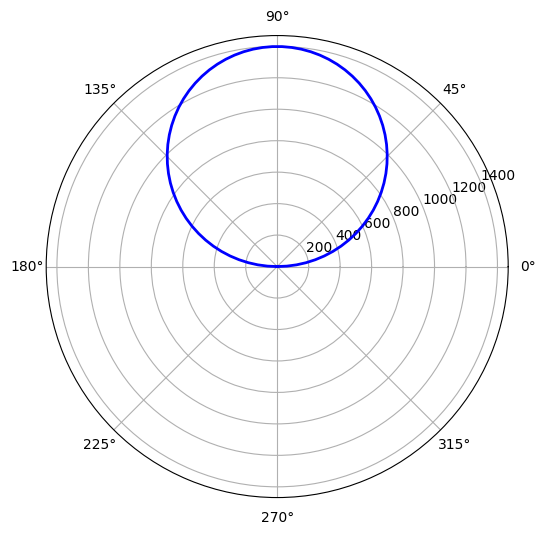

In [36]:
radian_angles = np.radians(angles)
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.plot(radian_angles,pl_theta_perpendicular, color='blue', linewidth=2, label="Oriented Lines")

Here,we plot radial plot of (pl)component of isotropic lines and angles

In [37]:
pl_theta_parallel = []
for x in angles :
  parallel_theta = pl_parallel*np.sin(np.radians(x))
  pl_theta_parallel.append(line_theta)
print(pl_theta_parallel)

[1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.712819538903443e-13, 1.71281953

<Figure size 800x600 with 0 Axes>

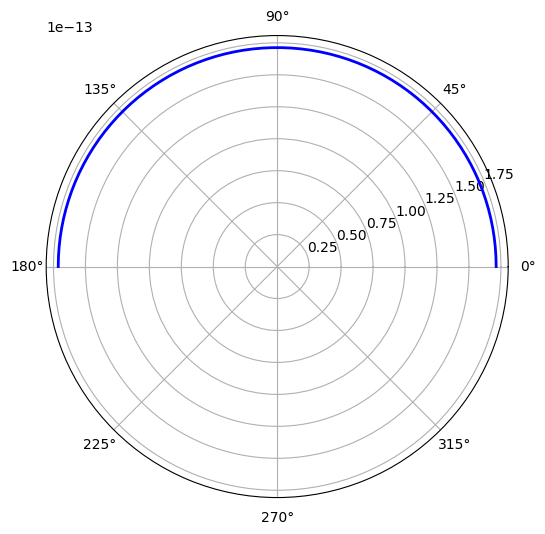

In [38]:
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.plot(radian_angles,pl_theta_parallel, color='blue', linewidth=2, label="Oriented Lines")

In [39]:
pl_overall = [1]*len(pl_theta_parallel)
for x in range(len(pl_theta_parallel)):
  pl_overall[x] = pl_theta_perpendicular[x] - pl_theta_parallel[x] + pl_parallel
print(pl_overall)

[1398.6232929330924, 1460.4890819875932, 1522.2337658547988, 1583.7364764165059, 1644.8768192286195, 1705.5351091989307, 1765.5926048763067, 1824.9317408926556, 1883.4363581026564, 1940.9919309707402, 1997.485791760206, 2052.807351085603, 2106.8483143966487, 2159.502893969895, 2210.6680159931657, 2260.2435223373827, 2308.13236662081, 2354.240804181899, 2398.4785755888697, 2440.759083326785, 2480.9995613162528, 2519.121236931914, 2555.049485203555, 2588.7139748979916, 2620.0488061957603, 2648.992639693111, 2675.488816476768, 2699.4854690364164, 2720.935622797786, 2739.7972880775887, 2756.0335422802946, 2769.612602175846, 2780.5078861168245, 2788.6980660732725, 2794.167109383314, 2796.904310137842, 2796.904310137842, 2794.167109383314, 2788.6980660732725, 2780.507886116824, 2769.612602175846, 2756.0335422802946, 2739.7972880775887, 2720.935622797786, 2699.4854690364164, 2675.488816476768, 2648.9926396931105, 2620.0488061957603, 2588.7139748979916, 2555.049485203555, 2519.121236931914, 24

This is a raidal plot of pl overall with angles

<Figure size 800x600 with 0 Axes>

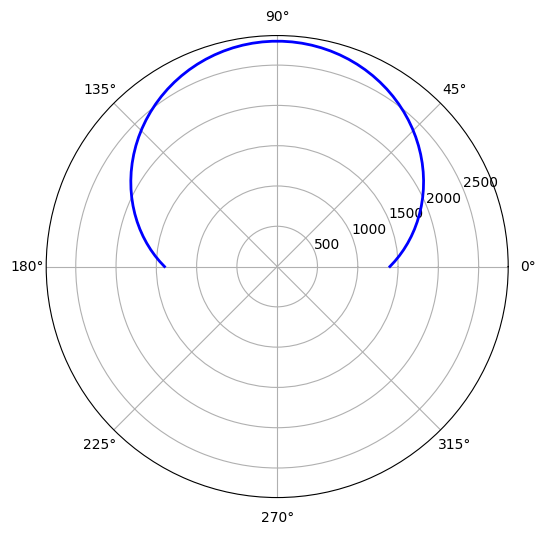

In [40]:
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.plot(radian_angles,pl_overall, color='blue', linewidth=2, label="Oriented Lines")

In [41]:
ba_isotropic  = np.pi*pl_parallel/2
ba_oriented =  - pl_parallel + pl_perpendicular
ba_overall = ba_isotropic + ba_oriented
print(ba_isotropic)
print(ba_oriented)
print(ba_overall)

2196.9523311090848
1763.819116771714
3960.771447880799


Calculation of degr

In [42]:
degree_of_orientation = (ba_oriented) / (ba_oriented + ba_isotropic)
print(degree_of_orientation)

0.4453221146389149
